# Functional analysis of re-calibrated (simplified) circuits

<u>Related ticket</u>: [ACCS-65](https://bbpteam.epfl.ch/project/issues/browse/ACCS-65)


In [1]:
import sys
sys.path.append('/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/cortex_etl')
import cortex_etl as c_etl
import matplotlib
import matplotlib.pyplot as plt
matplotlib.set_loglevel("error")
import numpy as np
import os
import pandas as pd
import tqdm
import yaml

In [2]:
figs_paths = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/calibration_v2/figs'
if not os.path.exists(figs_paths):
    os.makedirs(figs_paths)

In [3]:
ITER_NAMES = {_k: _v for _k, _v in enumerate(['first', 'second', 'third', 'fourth', 'fifth'])}

In [4]:
# Load .parquet files from re-calibration
order_list = [0, 1, 2, 3, 4, 5]  # 0...orig
desired_connected_proportion_of_invivo_frs = 0.3
iter_idx = 0  # 0..first, 1..second, ...

config_path = '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/sscx-workflows/simplified_connectome_models/calibration/notebooks'
calib_path = '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/sscx-workflows/simplified_connectome_models/calibration/workflows'
config_files = [f'connectome_rewiring_calibration_{_ord}-{iter_idx}.yaml' for _ord in order_list]
calib_files = [f'order{_ord}_connection_data_from_{ITER_NAMES[iter_idx]}_iteration.parquet' for _ord in order_list]
# ca = None
# depol_stdev_mean_ratio = None
calib_dfs = []
for _cfg, _cal in zip(config_files, calib_files):
    with open(os.path.join(config_path, _cfg), 'r') as f:
        cfg_dict = yaml.safe_load(f)
    vivo_frs = cfg_dict['analysis']['hex0_spikes']['custom']['vivo_frs']  # Load in-vivo reference firing rates from config

    df = pd.read_parquet(os.path.join(calib_path, _cal))
    df = df.loc[df['desired_connected_proportion_of_invivo_frs'] == desired_connected_proportion_of_invivo_frs]
    df['vivo_frs'] = [vivo_frs[_cl] for _cl in df['neuron_class']]  # Add in-vivo firing rates to data frame

#     if ca is None:
#         ca = np.unique(df['ca'])
#         assert len(ca) == 1, 'ERROR: Ca not unique!'
#         ca = ca[0]
#     else:
#         ca_tmp = np.unique(df['ca'])
#         assert len(ca_tmp) == 1 and ca_tmp[0] == ca, 'ERROR: Ca mismatch!'

#     if depol_stdev_mean_ratio is None:
#         depol_stdev_mean_ratio = np.unique(df['depol_stdev_mean_ratio'])
#         assert len(depol_stdev_mean_ratio) == 1, 'ERROR: Depol_stdev_mean_ratio not unique!'
#         depol_stdev_mean_ratio = depol_stdev_mean_ratio[0]
#     else:
#         depol_stdev_mean_ratio_tmp = np.unique(df['depol_stdev_mean_ratio'])
#         assert len(depol_stdev_mean_ratio_tmp) == 1 and depol_stdev_mean_ratio_tmp[0] == depol_stdev_mean_ratio, 'ERROR: Depol_stdev_mean_ratio mismatch!'

    calib_dfs.append(df)
neuron_classes = df['neuron_class'].tolist()

In [5]:
# # Ref. data (zeroth iteration)
# ref_file = 'concatented_mgfix_connection_data_15-11-22.parquet'
# ref_df = pd.read_parquet(os.path.join(calib_path, ref_file))
# ref_df = ref_df.loc[ref_df['desired_connected_proportion_of_invivo_frs'] == desired_connected_proportion_of_invivo_frs]
# ref_df = ref_df.loc[ref_df['ca'] == ca]
# ref_df = ref_df.loc[ref_df['depol_stdev_mean_ratio'] == depol_stdev_mean_ratio]
# ref_df = ref_df.loc[ref_df['window'] == 'conn_spont']

In [6]:
df.columns

Index(['circuit_id', 'neuron_class', 'window', 'mean_of_mean_spike_counts',
       'mean_of_mean_firing_rates_per_second',
       'std_of_mean_firing_rates_per_second', 'ca',
       'desired_connected_proportion_of_invivo_frs', 'depol_stdev_mean_ratio',
       'ei_corr_r_out_of_range', 'neuron_group_gt_threshold_fr', 'bursting',
       'bursting_or_fr_gt_threshold',
       'bursting_or_fr_gt_threshold_or_ei_corr_r_out_of_range',
       'desired_connected_fr', 'desired_unconnected_fr', 'depol_mean',
       'depol_sd', 'connection_fr_increase', 'connection_fr_error',
       'connection_vs_unconn_proportion', 'recorded_proportion_of_in_vivo_FR',
       'true_mean_conductance', 'vivo_frs'],
      dtype='object')

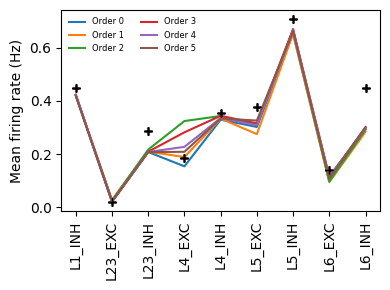

In [7]:
plt.figure(figsize=(4, 3))
for _ord, _df in zip(order_list, calib_dfs):
    plt.plot(range(len(neuron_classes)), _df['mean_of_mean_firing_rates_per_second'].values, label=f'Order {_ord}')
    plt.plot(range(len(neuron_classes)), _df['desired_connected_fr'].values, '+k')
plt.xticks(range(len(neuron_classes)), neuron_classes, rotation=90)
plt.ylabel('Mean firing rate (Hz)')
plt.legend(frameon=False, ncols=2, fontsize=6)
plt.tight_layout()
plt.show()

In [8]:
# _df['desired_connected_fr'] == _df['desired_connected_proportion_of_invivo_frs'].values * _df['vivo_frs'].values

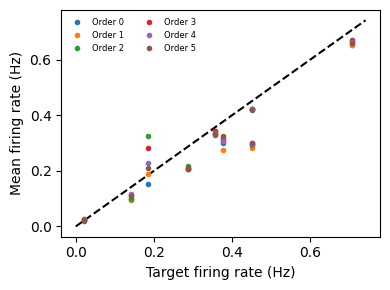

In [9]:
plt.figure(figsize=(4, 3))
for _ord, _df in zip(order_list, calib_dfs):
    plt.plot(_df['desired_connected_fr'].values, _df['mean_of_mean_firing_rates_per_second'].values, '.', label=f'Order {_ord}')
plt.plot(*([[0, np.max(plt.xlim())]] * 2), 'k--', zorder=0)
plt.xlabel('Target firing rate (Hz)')
plt.ylabel('Mean firing rate (Hz)')
plt.legend(frameon=False, ncols=2, fontsize=6)
plt.tight_layout()
plt.show()

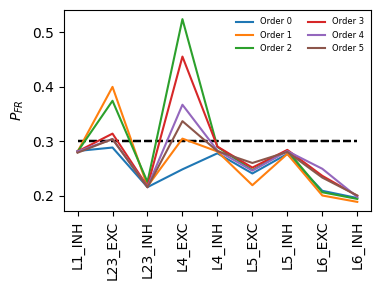

In [10]:
plt.figure(figsize=(4, 3))
for _ord, _df in zip(order_list, calib_dfs):
    plt.plot(range(len(neuron_classes)), _df['recorded_proportion_of_in_vivo_FR'].values, label=f'Order {_ord}')
    plt.plot(range(len(neuron_classes)), _df['desired_connected_proportion_of_invivo_frs'], 'k--', zorder=0)
plt.xticks(range(len(neuron_classes)), neuron_classes, rotation=90)
plt.ylabel('$P_{FR}$')
plt.legend(frameon=False, ncols=2, fontsize=6)
plt.tight_layout()
plt.show()

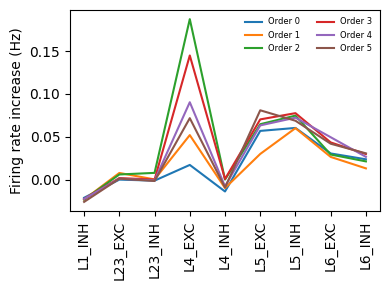

In [11]:
plt.figure(figsize=(4, 3))
for _ord, _df in zip(order_list, calib_dfs):
    plt.plot(range(len(neuron_classes)), _df['connection_fr_increase'].values, label=f'Order {_ord}')
plt.xticks(range(len(neuron_classes)), neuron_classes, rotation=90)
plt.ylabel('Firing rate increase (Hz)')
plt.legend(frameon=False, ncols=2, fontsize=6)
plt.tight_layout()
plt.show()

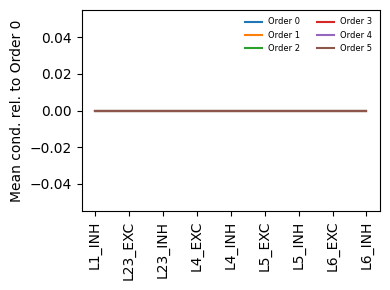

In [12]:
ref_idx = 0  # Original circuit = reference
ref_df = calib_dfs[ref_idx]
plt.figure(figsize=(4, 3))
for _ord, _df in zip(order_list, calib_dfs):
    # plt.plot(range(len(neuron_classes)), (_df['true_mean_conductance'].values - ref_df['true_mean_conductance'].values) / ref_df['true_mean_conductance'].values, label=f'Order {_ord}')
    plt.plot(range(len(neuron_classes)), (_df['true_mean_conductance'].values - ref_df['true_mean_conductance'].values) / (_df['true_mean_conductance'].values + ref_df['true_mean_conductance'].values), label=f'Order {_ord}')
    # plt.plot(range(len(neuron_classes)), _df['true_mean_conductance'].values - ref_df['true_mean_conductance'].values, label=f'Order {_ord}')
plt.xticks(range(len(neuron_classes)), neuron_classes, rotation=90)
plt.ylabel(f'Mean cond. rel. to Order {order_list[ref_idx]}')
plt.legend(frameon=False, ncols=2, fontsize=6)
plt.tight_layout()
plt.show()

In [ ]:
# TODO:
# Read rel. conductances from simulation configs (?): "inputs"->"Stimulus gExc_L1"->"mean_percent"
# Conductance vs. firing rates (w/o calib: same conductance, different resulting rates vs. fifth iteration calibration: same rates, different required conductaces)